In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from blocksparse_layer import BlockSparse
from sparsity_pattern_initializers import BarabasiAlbert
import matplotlib.pyplot as plt

In [2]:
# Load dataset
mnist = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create data generator for augmentation
train_gen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
train_gen.fit(x_train)
gen_flow = train_gen.flow(x_train, y_train, batch_size=64)

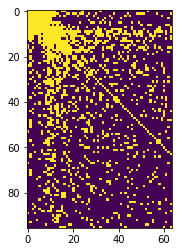

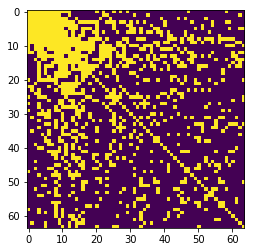

In [3]:
# Define model
input_shape = (x_train.shape[1:])

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    BlockSparse(units=2048,
                sparsity_mask_initializer=BarabasiAlbert(9),
                blocksize=32,
                feature_axis=0,
                activation=tf.nn.relu),
    BlockSparse(units=2048,
            sparsity_mask_initializer=BarabasiAlbert(9),
            blocksize=32,
            feature_axis=0,
            activation=tf.nn.relu),
    BlockSparse(units=1024,
            sparsity_mask_initializer=BarabasiAlbert(9),
            blocksize=32,
            feature_axis=0,
            activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Plot the layout of the blocksparse layers
plt.imshow(model.layers[1].bsmm.layout)
plt.show()

plt.imshow(model.layers[2].bsmm.layout)
plt.show()

In [4]:
# Compile train and evaluate
model.compile(optimizer=tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit_generator(gen_flow, epochs=70, workers=2, validation_data=(x_test, y_test))
model.summary()
model.evaluate(x_test, y_test)

Epoch 1/70
782/782 [==============================] - 20s 26ms/step - loss: 2.1556 - acc: 0.1753 - val_loss: 1.9805 - val_acc: 0.2634
Epoch 2/70
782/782 [==============================] - 19s 24ms/step - loss: 1.9448 - acc: 0.2841 - val_loss: 1.8054 - val_acc: 0.3467
Epoch 3/70
782/782 [==============================] - 19s 24ms/step - loss: 1.8231 - acc: 0.3385 - val_loss: 1.7055 - val_acc: 0.3920
Epoch 4/70
782/782 [==============================] - 19s 24ms/step - loss: 1.7375 - acc: 0.3737 - val_loss: 1.6294 - val_acc: 0.4147
Epoch 5/70
782/782 [==============================] - 19s 24ms/step - loss: 1.6781 - acc: 0.3951 - val_loss: 1.5671 - val_acc: 0.4417
Epoch 6/70
782/782 [==============================] - 19s 24ms/step - loss: 1.6381 - acc: 0.4073 - val_loss: 1.5279 - val_acc: 0.4520
Epoch 7/70
782/782 [==============================] - 18s 24ms/step - loss: 1.5968 - acc: 0.4240 - val_loss: 1.5178 - val_acc: 0.4590
Epoch 8/70
782/782 [==============================] - 19s 24ms

Epoch 62/70
782/782 [==============================] - 19s 24ms/step - loss: 1.0013 - acc: 0.6379 - val_loss: 1.1774 - val_acc: 0.5915
Epoch 63/70
782/782 [==============================] - 19s 24ms/step - loss: 0.9975 - acc: 0.6402 - val_loss: 1.1649 - val_acc: 0.5906
Epoch 64/70
782/782 [==============================] - 19s 24ms/step - loss: 0.9974 - acc: 0.6412 - val_loss: 1.1380 - val_acc: 0.6026
Epoch 65/70
782/782 [==============================] - 19s 24ms/step - loss: 0.9841 - acc: 0.6466 - val_loss: 1.1528 - val_acc: 0.6013
Epoch 66/70
782/782 [==============================] - 19s 24ms/step - loss: 0.9766 - acc: 0.6470 - val_loss: 1.1571 - val_acc: 0.5991
Epoch 67/70
782/782 [==============================] - 19s 24ms/step - loss: 0.9770 - acc: 0.6464 - val_loss: 1.1541 - val_acc: 0.6029
Epoch 68/70
782/782 [==============================] - 19s 24ms/step - loss: 0.9671 - acc: 0.6525 - val_loss: 1.1385 - val_acc: 0.6029
Epoch 69/70
782/782 [==============================] - 

[1.1449687225341796, 0.6085]

In [5]:
# Save the model and reload it
model.save('blocksparse_model.h5')
del model

model = tf.keras.models.load_model('blocksparse_model.h5', custom_objects={'BlockSparse':BlockSparse})
model.compile(optimizer=tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 92us/step


[1.144968727684021, 0.6085]

In [6]:
# Save and restore using model config and get weights seperately
config = model.get_config()
weights = model.get_weights()
del model

model = tf.keras.Sequential.from_config(config, custom_objects={'BlockSparse':BlockSparse})
model.set_weights(weights)

model.compile(optimizer=tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 94us/step


[1.1449687286376953, 0.6085]